<a href="https://colab.research.google.com/github/RkanGen/LLM-RAG/blob/main/Multi_Modal_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal RAG Tutorial using GPT-4 and LlamaIndex

## Table of Contents
1. Introduction to Multimodal RAG
2. Setup and Installation
3. Preparing the Environment
4. Data Collection and Preparation
5. Building the Multimodal Index
6. Implementing Multimodal Retrieval
8. Multimodal RAG Querying


## 1. Introduction to Multimodal RAG

Multimodal Retrieval-Augmented Generation (RAG) is an advanced technique that combines text and image data to enhance the capabilities of large language models (LLMs) like GPT-4. This tutorial will guide you through the process of implementing a multimodal RAG system using GPT-4 and LlamaIndex.

### How Multimodal RAG Works

Multimodal RAG extends traditional text-based RAG by incorporating image data:

1. **Indexing**: Both text and images are processed and stored in separate vector stores.
2. **Retrieval**: When a query is received, relevant text and images are retrieved based on similarity.
3. **Augmentation**: The retrieved information is used to augment the input to the LLM.
4. **Generation**: The LLM generates a response based on the augmented input.


## 2. Setup and Installation
First, we need to install the required dependencies. We'll use a virtual environment to keep our project isolated.


In [ ]:
!pip install llama-index-embeddings-clip

  Using cached pillow-10.4.0-cp310-cp310-manylinux_2_28_x86_64.whl (4.5 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 10.0.1
    Uninstalling Pillow-10.0.1:
      Successfully uninstalled Pillow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.4.0 which is incompatible.


In [ ]:
# Create a virtual environment
# python -m venv multimodal_rag_env

# Activate the virtual environment
# On Windows:
# multimodal_rag_env\Scripts\activate
# On macOS and Linux:
# source multimodal_rag_env/bin/activate

# Install required packages
!pip install llama-index-multi-modal-llms-openai
!pip install llama-index-vector-stores-qdrant
!pip install llama_index ftfy regex tqdm
!pip install torch torchvision
!pip install matplotlib scikit-image
!pip install -U qdrant_client

  Using cached Pillow-10.0.1-cp310-cp310-manylinux_2_28_x86_64.whl (3.6 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 10.4.0
    Uninstalling pillow-10.4.0:
      Successfully uninstalled pillow-10.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index-embeddings-clip 0.1.5 requires pillow<11.0.0,>=10.2.0, but you have pillow 10.0.1 which is incompatible.


ERROR: Operation cancelled by user


## 3. Preparing the Environment
Now, let's set up our Python environment and configure the OpenAI API key.

In [ ]:
import os
import requests
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

# Set your OpenAI API key

from google.colab import userdata

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY') #"your_api_key_here"
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY



In [ ]:
# Create necessary directories
input_image_path = Path("input_images")
data_path = Path("mixed_wiki")

for path in [input_image_path, data_path]:
    if not path.exists():
        Path.mkdir(path)

print("Environment prepared successfully!")

Environment prepared successfully!


#### Example Images

In [ ]:
!wget "https://docs.google.com/uc?export=download&id=1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj" -O ./input_images/long_range_spec.png
!wget "https://docs.google.com/uc?export=download&id=19pLwx0nVqsop7lo0ubUSYTzQfMtKJJtJ" -O ./input_images/model_y.png
!wget "https://docs.google.com/uc?export=download&id=1utu3iD9XEgR5Sb7PrbtMf1qw8T1WdNmF" -O ./input_images/performance_spec.png
!wget "https://docs.google.com/uc?export=download&id=1dpUakWMqaXR4Jjn1kHuZfB0pAXvjn2-i" -O ./input_images/price.png
!wget "https://docs.google.com/uc?export=download&id=1qNeT201QAesnAP5va1ty0Ky5Q_jKkguV" -O ./input_images/real_wheel_spec.png

--2024-07-12 03:51:40--  https://docs.google.com/uc?export=download&id=1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj
Resolving docs.google.com (docs.google.com)... 172.217.0.78, 2607:f8b0:4025:810::200e
Connecting to docs.google.com (docs.google.com)|172.217.0.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj&export=download [following]
--2024-07-12 03:51:40--  https://drive.usercontent.google.com/download?id=1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.15.225, 2607:f8b0:4025:802::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.15.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160684 (157K) [image/png]
Saving to: ‘./input_images/long_range_spec.png’

./input_images/long 100%[===================>] 156.92K  --.-KB/s    in 0.04s  

#### Let's look at the images

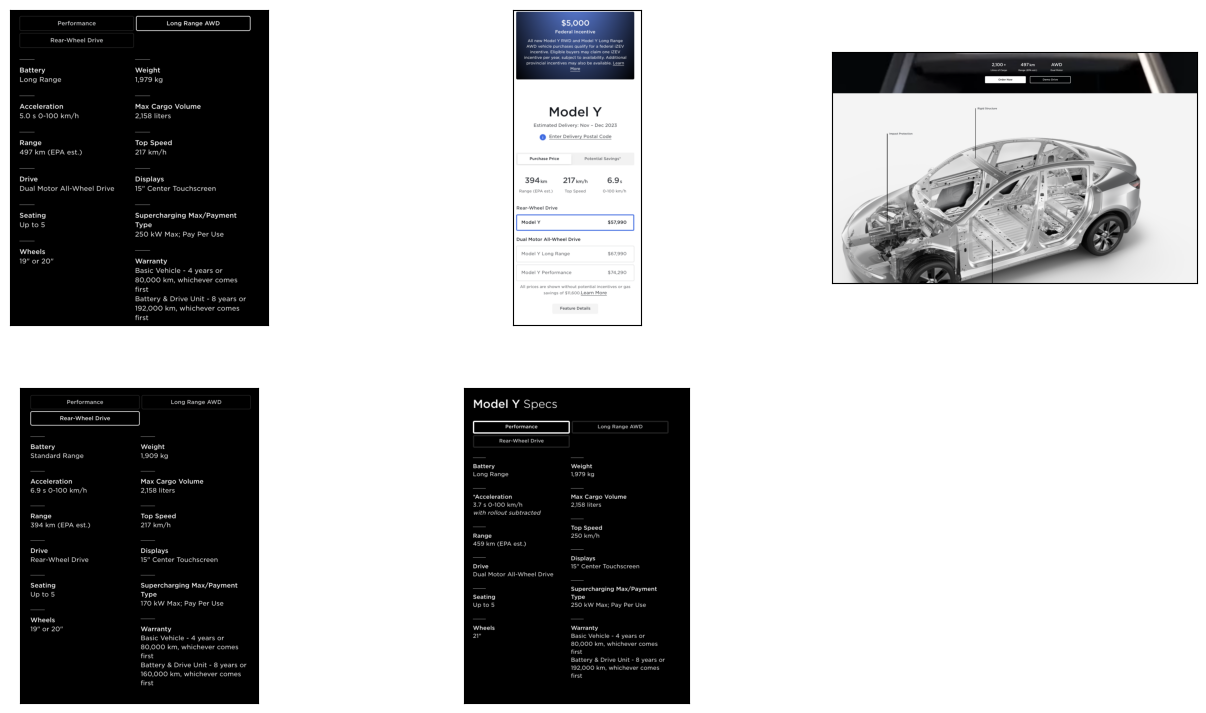

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./input_images"):
    image_paths.append(str(os.path.join("./input_images", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

### Genereate text descriptions for images using GPT-4o

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import SimpleDirectoryReader

# put your local directore here
image_documents = SimpleDirectoryReader("./input_images").load_data()

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key=OPENAI_API_KEY, max_new_tokens=1500
)

response_1 = openai_mm_llm.complete(
    prompt="Generate detailed text description for each image.",
    image_documents=image_documents,
)

print(response_1)

### Image 1: Specifications for Long Range AWD Model
- **Battery**: Long Range
- **Weight**: 1,979 kg
- **Acceleration**: 5.0 s 0-100 km/h
- **Max Cargo Volume**: 2,158 liters
- **Range**: 497 km (EPA est.)
- **Top Speed**: 217 km/h
- **Drive**: Dual Motor All-Wheel Drive
- **Displays**: 15" Center Touchscreen
- **Seating**: Up to 5
- **Supercharging Max/Payment Type**: 250 kW Max; Pay Per Use
- **Wheels**: 19" or 20"
- **Warranty**:
  - Basic Vehicle: 4 years or 80,000 km, whichever comes first
  - Battery & Drive Unit: 8 years or 192,000 km, whichever comes first

### Image 2: Structural Diagram of the Vehicle
- The image shows a detailed structural diagram of a vehicle, highlighting key components:
  - **Rigid Structure**: Emphasizes the vehicle's robust frame.
  - **Impact Protection**: Indicates areas designed for enhanced safety during collisions.

### Image 3: Model Y Specifications
- **Battery**: Long Range
- **Weight**: 1,979 kg
- **Acceleration**: 3.7 s 0-100 km/h (with rollo

## 4. Data Collection and Preparation
In this section, we'll collect text and image data from Wikipedia and other sources.

In [ ]:
def get_wikipedia_images(title):
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "imageinfo",
            "iiprop": "url|dimensions|mime",
            "generator": "images",
            "gimlimit": "50",
        },
    ).json()
    image_urls = []
    for page in response["query"]["pages"].values():
        if page["imageinfo"][0]["url"].endswith((".jpg", ".png")):
            image_urls.append(page["imageinfo"][0]["url"])
    return image_urls


In [ ]:
# List of Wikipedia titles to fetch
wiki_titles = {
    "Tesla Model Y",
    "Tesla Model X",
    "Tesla Model 3",
    "Tesla Model S",
    "Kia EV6",
    "BMW i3",
    "Audi e-tron",
    "Ford Mustang",
    "Porsche Taycan",
    "Rivian",
    "Polestar",
}


In [ ]:
# Fetch text and images
import urllib

image_uuid = 0
MAX_IMAGES_PER_WIKI = 20

for title in wiki_titles:
    # Fetch text
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

    # Fetch images
    images_per_wiki = 0
    list_img_urls = get_wikipedia_images(title)

    for url in list_img_urls:
        if url.endswith((".jpg", ".png", ".svg")):
            image_uuid += 1
            urllib.request.urlretrieve(
                    url, data_path / f"{image_uuid}.jpg"
                )
            images_per_wiki += 1
            if images_per_wiki >= MAX_IMAGES_PER_WIKI:
                break

print("Data collection completed!")

HTTPError: HTTP Error 429: Too many requests. Please comply with the User-Agent policy to get a higher rate limit: https://meta.wikimedia.org/wiki/User-Agent_policy

In [ ]:
!wget "https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1" -O ./mixed_wiki/tesla_2021_10k.htm


--2024-07-12 03:55:01--  https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd894547e8c55169572b31b0fc1.dl.dropboxusercontent.com/cd/0/inline/CWh9Bpxp7_ceJsr_dZIWi_JOfWyrNej7HVLbJjtWKynXdO3feUpHWxKWVWs6nmTyruKDlJW7ALmBUUpvOrrBDOLE7bwwDRgnLNpwrCyu7IIcqS2WQKtGiauLd7lM3qWiBaU/file?dl=1# [following]
--2024-07-12 03:55:02--  https://ucd894547e8c55169572b31b0fc1.dl.dropboxusercontent.com/cd/0/inline/CWh9Bpxp7_ceJsr_dZIWi_JOfWyrNej7HVLbJjtWKynXdO3feUpHWxKWVWs6nmTyruKDlJW7ALmBUUpvOrrBDOLE7bwwDRgnLNpwrCyu7IIcqS2WQKtGiauLd7lM3qWiBaU/file?dl=1
Resolving ucd894547e8c55169572b31b0fc1.dl.dropboxusercontent.com (ucd894547e8c55169572b31b0fc1.dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6019:15::a27d:40

## 5. Building the Multimodal Index
Now that we have our data, let's build the multimodal index using LlamaIndex and Qdrant as our vector store.

In [ ]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext
import qdrant_client

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(client=client, collection_name="text_collection")
image_store = QdrantVectorStore(client=client, collection_name="image_collection")

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

print("Multimodal index built successfully!")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (101972528 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|███████████████████████████████████████| 338M/338M [00:12<00:00, 28.0MiB/s]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (101972528 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Multimodal index built successfully!


## 6. Implementing Multimodal Retrieval
Let's create a retriever engine that can fetch both text and images based on a query.

In [ ]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

MAX_TOKENS = 50
retriever_engine = index.as_retriever(
    similarity_top_k=3, image_similarity_top_k=3
)

def retrieve_and_display(query):
    retrieval_results = retriever_engine.retrieve(query[:MAX_TOKENS])

    retrieved_images = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_images.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)

    if retrieved_images:
        plt.figure(figsize=(15, 5))
        for i, img_path in enumerate(retrieved_images):
            plt.subplot(1, len(retrieved_images), i+1)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

# Example usage
# retrieve_and_display("Tell me about electric cars")

**Node ID:** 0bae195f-0cba-465c-848e-10f4c65b8b17<br>**Similarity:** 0.8382498916797606<br>**Text:** The Tesla Model S is a battery electric executive car with a liftback body style built by Tesla, Inc. since 2012. The Model S features a battery-powered dual-motor, all-wheel drive layout, although...<br>

**Node ID:** 5b0cf37d-c7f6-4b7d-99b0-bb3545d58f35<br>**Similarity:** 0.8275277916243806<br>**Text:** The Tesla Model X is a battery electric mid-size luxury crossover SUV built by Tesla, Inc. since 2015. Developed from the full-sized sedan platform of the Tesla Model S, the vehicle notably uses fa...<br>

**Node ID:** 023c1d41-d26e-4463-98fa-f3c2ab0843ae<br>**Similarity:** 0.8248738040050201<br>**Text:** === Power discrepancy ===
The P85D "insane mode" was widely reported to have 691 horsepower, but some owners reported 20% less power on the dynamometer in various circumstances. As of November 2015...<br>

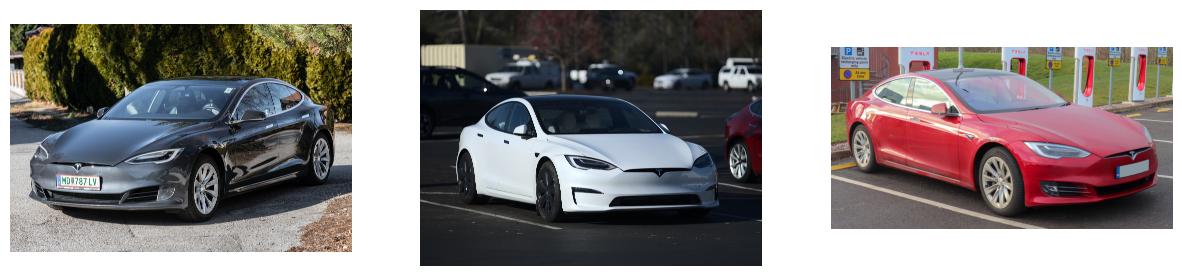

In [ ]:
retrieve_and_display("What is the best electric Sedan?")

## 7. Multimodal RAG Querying
Finally, let's implement a multimodal RAG query engine that can answer questions using both text and image data.

Answer: The design features of the Tesla Model S and Rivian R1T/R1S can be compared as follows:

### Tesla Model S:
1. **Body Style**: The Tesla Model S is a battery electric executive car with a liftback body style.
2. **Powertrain**: It features a battery-powered dual-motor, all-wheel drive layout, although earlier versions had a rear-motor and rear-wheel drive layout.
3. **Design Evolution**: The Model S has undergone several updates, including a major design refresh in April 2016 with a new front hood design and another in June 2021 with the "Palladium" update, which introduced the "Plaid" performance model.
4. **Range**: The Model S P100D was the first electric vehicle to have an EPA estimated range exceeding 300 miles (483 km).
5. **Interior**: The 2021 refresh included a revised interior, powertrain, and suspension.
6. **Additional Features**: The Model S offers features such as a front trunk ("frunk") in addition to a rear trunk and an enlarged crumple zone.

### Rivian R1T/R1S

**Node ID:** 2504dbf2-02ff-409f-8c29-2cd3d073fa29<br>**Similarity:** 0.856449694206673<br>**Text:** === R1T ===

The R1T is a pickup truck, which features four electric motors, two located on each axle (front and rear). The front two motors produce 415 hp (309 kW) and 413 lb⋅ft (560 N⋅m) of torqu...<br>

**Node ID:** 0bae195f-0cba-465c-848e-10f4c65b8b17<br>**Similarity:** 0.8427382398090341<br>**Text:** The Tesla Model S is a battery electric executive car with a liftback body style built by Tesla, Inc. since 2012. The Model S features a battery-powered dual-motor, all-wheel drive layout, although...<br>

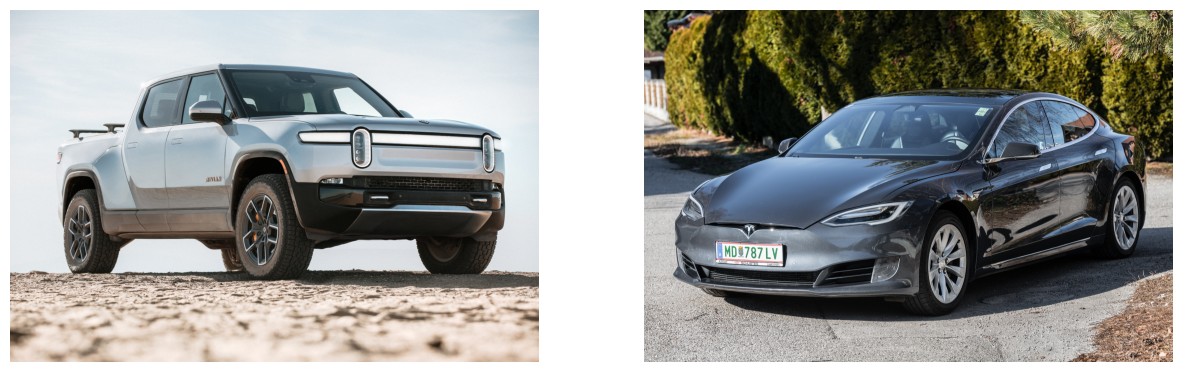

In [ ]:
from llama_index.core import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngine

qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=openai_mm_llm, text_qa_template=qa_tmpl
)

def multimodal_rag_query(query_str):
    response = query_engine.query(query_str)
    print("Answer:", str(response))

    print("\nSources:")
    for text_node in response.metadata["text_nodes"]:
        display_source_node(text_node, source_length=200)

    if response.metadata["image_nodes"]:
        plt.figure(figsize=(15, 5))
        for i, img_node in enumerate(response.metadata["image_nodes"]):
            plt.subplot(1, len(response.metadata["image_nodes"]), i+1)
            img = Image.open(img_node.metadata["file_path"])
            plt.imshow(img)
            plt.axis('off')
        plt.show()

# Example usage
multimodal_rag_query("Compare the design features of Tesla Model S and Rivian R1")